In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/zaSIG10/Events/run_01/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

bg_aa_rootpath = "/data/Chen-Wang/llaaBG/Events/run_01/tag_1_delphes_events.root"
bg_aa_file = uproot.open(bg_aa_rootpath)

bg_jet_rootpath = "/data/Chen-Wang/lljBG/Events/run_01/tag_1_delphes_events.root"
bg_jet_file = uproot.open(bg_jet_rootpath)

In [3]:
##### set signal event content #####

sig_events = [sig_file["Delphes;1"]["Electron"].array(),
              sig_file["Delphes;1"]["Electron.PT"].array(),
              sig_file["Delphes;1"]["Electron.Eta"].array(),
              sig_file["Delphes;1"]["Electron.Phi"].array(),
              sig_file["Delphes;1"]["Muon"].array(),
              sig_file["Delphes;1"]["Muon.PT"].array(),
              sig_file["Delphes;1"]["Muon.Eta"].array(),
              sig_file["Delphes;1"]["Muon.Phi"].array(),
              sig_file["Delphes;1"]["Jet"].array(),
              sig_file["Delphes;1"]["Jet.EhadOverEem"].array(),
              sig_file["Delphes;1"]["Jet.Mass"].array(),
              sig_file["Delphes;1"]["Event.Number"].array(),
              sig_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

sig_events = np.expand_dims(sig_events, axis=-1)    ### reshape data
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

##### set llaa background event content #####

bg_aa_events = [bg_aa_file["Delphes;1"]["Electron"].array(),
             bg_aa_file["Delphes;1"]["Electron.PT"].array(),
             bg_aa_file["Delphes;1"]["Electron.Eta"].array(),
             bg_aa_file["Delphes;1"]["Electron.Phi"].array(),
             bg_aa_file["Delphes;1"]["Muon"].array(),
             bg_aa_file["Delphes;1"]["Muon.PT"].array(),
             bg_aa_file["Delphes;1"]["Muon.Eta"].array(),
             bg_aa_file["Delphes;1"]["Muon.Phi"].array(),
             bg_aa_file["Delphes;1"]["Jet"].array(),
             bg_aa_file["Delphes;1"]["Jet.EhadOverEem"].array(),
             bg_aa_file["Delphes;1"]["Jet.Mass"].array(),
             bg_aa_file["Delphes;1"]["Event.Number"].array(),
             bg_aa_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

bg_aa_events = np.expand_dims(bg_aa_events, axis=-1)    ### reshape data
bg_aa_events = bg_aa_events.transpose((1,0,2))
bg_aa_events = np.squeeze(bg_aa_events,axis=(2,))

##### set llj background event content #####

bg_jet_events = [bg_jet_file["Delphes;1"]["Electron"].array(),
             bg_jet_file["Delphes;1"]["Electron.PT"].array(),
             bg_jet_file["Delphes;1"]["Electron.Eta"].array(),
             bg_jet_file["Delphes;1"]["Electron.Phi"].array(),
             bg_jet_file["Delphes;1"]["Muon"].array(),
             bg_jet_file["Delphes;1"]["Muon.PT"].array(),
             bg_jet_file["Delphes;1"]["Muon.Eta"].array(),
             bg_jet_file["Delphes;1"]["Muon.Phi"].array(),
             bg_jet_file["Delphes;1"]["Jet"].array(),
             bg_jet_file["Delphes;1"]["Jet.EhadOverEem"].array(),
             bg_jet_file["Delphes;1"]["Jet.Mass"].array(),
             bg_jet_file["Delphes;1"]["Event.Number"].array(),
             bg_jet_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

bg_jet_events = np.expand_dims(bg_jet_events, axis=-1)    ### reshape data
bg_jet_events = bg_jet_events.transpose((1,0,2))
bg_jet_events = np.squeeze(bg_jet_events,axis=(2,))

##### event features #####

features = ["Electron", "Electron.PT", "Electron.Eta", "Electron.Phi", "Muon", "Muon.PT", "Muon.Eta", "Muon.Phi", "Jet", "Jet.EhadOverEem", "Jet.Mass", "Event.Number", "Jet.Tau[5]"]
electron_mass = 0.000511
muon_mass = 0.10566

In [4]:
################################
##### Some useful function #####
################################

##### select if =2 photon #####
#
#def photon_selection(events):
#    where2photon = np.where(events[:,8]==2)    ### 8:number of photon
#    return events[where2photon]

##### select at least 1 jet #####

def jet_selection(events):
    where1 = np.where(events[:,8]>0)    ### 8:number of jets
    return events[where1]

##### select minimum theta <0.02

def theta_selection(events):
    where1 = []
    for i in range(len(events)):
        min_theta = np.min(events[i][9])    ### 9:jet theta (Jet.EhadOverEem)
        if min_theta<0.02:
            where1.append(i)
    return events[where1]

##### select if =2 lepton #####

def lepton_selection(events):
    where_electron = np.where(events[:,0]==2)    ### 0:number of electron
    where_muon = np.where(events[:,4]==2)    ### 4:number of muon
    return events[where_electron], events[where_muon]

##### calculate m_ll #####

def m_ll(events, m_ll):
    where1 = []
    where_select = []
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        if events[i][0]==2:    ### electron case
            for j in range(2):
                pt = events[i][1][j]    ### 1:electron transverse momentum
                phi = events[i][2][j]    ### 2:electron polar angle
                eta = events[i][3][j]    ### 3:electron pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( electron_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        elif events[i][4]==2:    ### muon case
            for j in range(2):
                pt = events[i][5][j]    ### 5:muon transverse momentum
                phi = events[i][6][j]    ### 6:muon polar angle
                eta = events[i][7][j]    ### 7:muon pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( muon_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        mll = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        if 30<=mll<=250:
            m_ll.append(mll)
            where1.append(i)
        if 75<=mll<=115:
            where_select.append(i)
    return events[where1], events[where_select]

##### calculate m_aa and pT_aa #####
#
#def m_aa(events, m_aa, pT_aa):
#    for i in range(len(events)):
#        p = [0,0,0,0]    ### four momentum
#        for j in range(events[i][8]):
#            pt = events[i][9][j]    ### 9:photon transverse momentum
#            phi = events[i][10][j]    ### 10:photon polar angle
#            eta = events[i][11][j]    ### 11:photon pseudorapidity
#            p[1] = p[1] + pt*np.cos(phi)    ### px
#            p[2] = p[2] + pt*np.sin(phi)    ### py
#            p[3] = p[3] + pt*np.sinh(eta)    ### pz
#            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy with photon mass=0
#        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
#        m_aa.append(maa)
#        pTaa = np.sqrt(p[1]**2 + p[2]**2)
#        pT_aa.append(pTaa)
        
##### collect jet mass #####

def m_jet(events, m_jet):
    where1 = []
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            jet_mass = events[i][10][where_min_theta[j]]    ### 10:jet mass
            if 2<jet_mass<18:
            #if 9<jet_mass<12:
                where1.append(i)
                m_jet.append(jet_mass)
    where1 = np.unique(where1)
    return events[where1]

##### select jet mass #####

def select_m_jet(events):
    where1 = []
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            jet_mass = events[i][10][where_min_theta[j]]    ### 10:jet mass
            if 9<jet_mass<12:
                where1.append(i)
    where1 = np.unique(where1)
    return events[where1]

##### comute Tau2/Tau1 (N-subjettiness) #####

def Tau2overTau1(events, Tau2overTau1):
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            Tau1 = events[i][12][where_min_theta[j]][0]
            Tau2 = events[i][12][where_min_theta[j]][1]
            if Tau1!=0:
                Tau2overTau1.append(Tau2/Tau1)

In [5]:
##### signal events selection #####

print("total signal events:", len(sig_events))
sig_events = jet_selection(sig_events)
print("events after 1 jet selection:", len(sig_events))
sig_events = theta_selection(sig_events)
print("events after minimum theta selection:", len(sig_events))
sig_electron_events, sig_muon_events = lepton_selection(sig_events)
print("2 electron events:", len(sig_electron_events))
print("2 muon events:", len(sig_muon_events))

##### 2 photon background events selection #####

print("\ntotal 2 photon background events:", len(bg_aa_events))
bg_aa_events = jet_selection(bg_aa_events)
print("events after 1 jet selection:", len(bg_aa_events))
bg_aa_events = theta_selection(bg_aa_events)
print("events after minimum theta selection:", len(bg_aa_events))
bg_aa_electron_events, bg_aa_muon_events = lepton_selection(bg_aa_events)
print("2 electron events:", len(bg_aa_electron_events))
print("2 muon events:", len(bg_aa_muon_events))

##### jet background events selection #####

print("\ntotal 1 jet background events:", len(bg_jet_events))
bg_jet_events = jet_selection(bg_jet_events)
print("events after 1 jet selection:", len(bg_jet_events))
bg_jet_events = theta_selection(bg_jet_events)
print("events after minimum theta selection:", len(bg_jet_events))
bg_jet_electron_events, bg_jet_muon_events = lepton_selection(bg_jet_events)
print("2 electron events:", len(bg_jet_electron_events))
print("2 muon events:", len(bg_jet_muon_events))

total signal events: 10000
events after 1 jet selection: 8349
events after minimum theta selection: 6343
2 electron events: 857
2 muon events: 1235

total 2 photon background events: 10000
events after 1 jet selection: 5831
events after minimum theta selection: 2692
2 electron events: 156
2 muon events: 243

total 1 jet background events: 10000
events after 1 jet selection: 8457
events after minimum theta selection: 1642
2 electron events: 12
2 muon events: 27


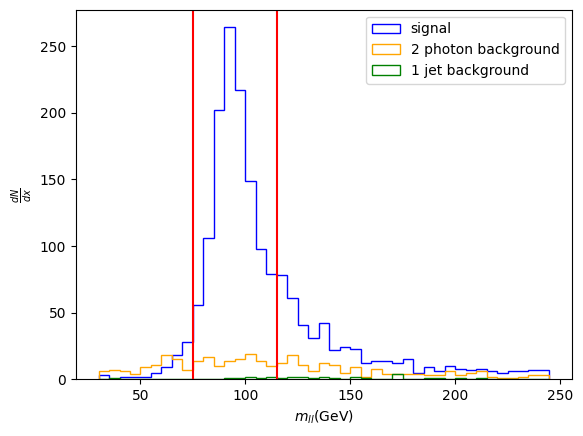

signal events: 1721
2 photon background events: 346
1 jet background events: 28

selected signal events: 1171
selected 2 photon background events: 113
selected 1 jet background events: 7


In [6]:
##### plot m_ll #####

sig_m_ll = []
bg_aa_m_ll = []
bg_jet_m_ll = []

sig_electron_events, sig_electron_select = m_ll(sig_electron_events, sig_m_ll)
sig_muon_events, sig_muon_select = m_ll(sig_muon_events, sig_m_ll)

bg_aa_electron_events, bg_aa_electron_select = m_ll(bg_aa_electron_events, bg_aa_m_ll)
bg_aa_muon_events, bg_aa_muon_select = m_ll(bg_aa_muon_events, bg_aa_m_ll)

bg_jet_electron_events, bg_jet_electron_select = m_ll(bg_jet_electron_events, bg_jet_m_ll)
bg_jet_muon_events, bg_jet_muon_select = m_ll(bg_jet_muon_events, bg_jet_m_ll)

bins = np.arange(30,250,5)
plt.hist(sig_m_ll, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_m_ll, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_m_ll, bins=bins, label="1 jet background", histtype='step', color='green')
plt.axvline(75, color='r')
plt.axvline(115, color='r')
plt.xlabel(r"$m_{ll}$(GeV)")
plt.ylabel(r"$\frac{dN}{dx}$")
#plt.text(140,145,"1348 signal events")
#plt.text(140,155,"141 2-photon background events")
#plt.text(140,165,"13 jet background events")
plt.legend(loc='best')
plt.show()

print("signal events:", len(sig_m_ll))
print("2 photon background events:", len(bg_aa_m_ll))
print("1 jet background events:", len(bg_jet_m_ll))

print("\nselected signal events:", len(sig_electron_select)+len(sig_muon_select))
print("selected 2 photon background events:", len(bg_aa_electron_select)+len(bg_aa_muon_select))
print("selected 1 jet background events:", len(bg_jet_electron_select)+len(bg_jet_muon_select))

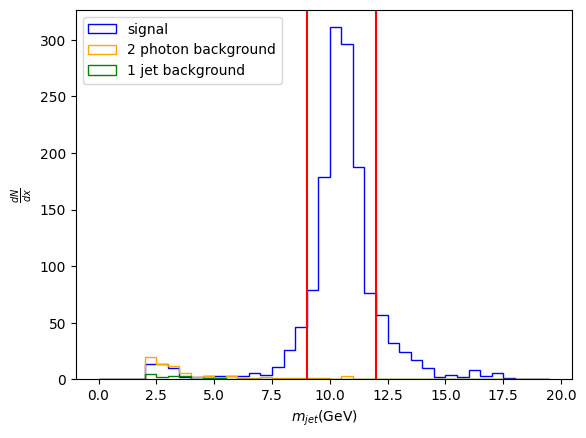

signal events: 1442
2 photon background events: 73
1 jet background events: 15

average signal jet mass: 10.429362


In [7]:
##### plot m_jet #####

sig_m_jet = []
bg_aa_m_jet = []
bg_jet_m_jet = []

sig_electron_events = m_jet(sig_electron_events, sig_m_jet)
sig_muon_events = m_jet(sig_muon_events, sig_m_jet)

bg_aa_electron_events = m_jet(bg_aa_electron_events, bg_aa_m_jet)
bg_aa_muon_events = m_jet(bg_aa_muon_events, bg_aa_m_jet)

bg_jet_electron_events = m_jet(bg_jet_electron_events, bg_jet_m_jet)
bg_jet_muon_events = m_jet(bg_jet_muon_events, bg_jet_m_jet)

bins = np.arange(0, 20, 0.5)
sig = plt.hist(sig_m_jet, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_m_jet, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_m_jet, bins=bins, label="1 jet background", histtype='step', color='green')
plt.xlabel(r"$m_{jet}$(GeV)")
plt.ylabel(r"$\frac{dN}{dx}$")
#plt.text(170,60,"58 signal events")
#plt.text(170,65,"1670 background events")
plt.axvline(9, color='r')
plt.axvline(12, color='r')
plt.legend(loc='best')
plt.show()

print("signal events:", len(sig_m_jet))
print("2 photon background events:", len(bg_aa_m_jet))
print("1 jet background events:", len(bg_jet_m_jet))
print("\naverage signal jet mass:", np.average(sig_m_jet))

In [8]:
##### select m_jet #####

sig_electron_select = select_m_jet(sig_electron_select)
sig_muon_select = select_m_jet(sig_muon_select)

#bg_aa_electron_select = select_m_jet(bg_aa_electron_select)
bg_aa_muon_select = select_m_jet(bg_aa_muon_select)

#bg_jet_electron_select = select_m_jet(bg_jet_electron_select)
#bg_jet_muon_select = select_m_jet(bg_jet_muon_select)

print("signal events after m_jet selection:", len(sig_electron_select)+len(sig_muon_select))
print("2 photon background events after m_jet selection:", 0+len(bg_aa_muon_select))
print("1 jet background events after m_jet selection:", 0+0)

signal events after m_jet selection: 808
2 photon background events after m_jet selection: 1
1 jet background events after m_jet selection: 0


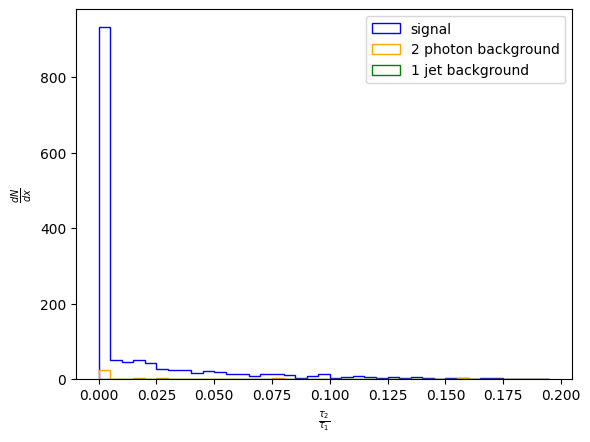

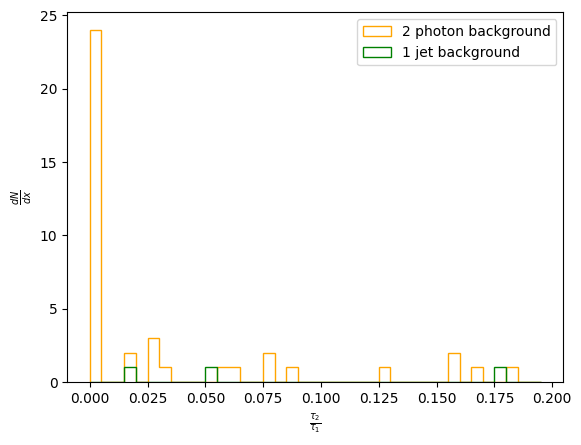

In [9]:
##### plot Tau2/Tau1 (N-subjettiness) #####

sig_Tau2overTau1 = []
bg_aa_Tau2overTau1 = []
bg_jet_Tau2overTau1 = []

Tau2overTau1(sig_electron_events, sig_Tau2overTau1)
Tau2overTau1(sig_muon_events, sig_Tau2overTau1)

Tau2overTau1(bg_aa_electron_events, bg_aa_Tau2overTau1)
Tau2overTau1(bg_aa_muon_events, bg_aa_Tau2overTau1)

Tau2overTau1(bg_jet_electron_events, bg_jet_Tau2overTau1)
Tau2overTau1(bg_jet_muon_events, bg_jet_Tau2overTau1)

bins = np.arange(0,0.2,0.005)
plt.hist(sig_Tau2overTau1, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_Tau2overTau1, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_Tau2overTau1, bins=bins, label="1 jet background", histtype='step', color='green')
plt.xlabel(r"$\frac{\tau_2}{\tau_1}$")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

plt.hist(bg_aa_Tau2overTau1, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_Tau2overTau1, bins=bins, label="1 jet background", histtype='step', color='green')
plt.xlabel(r"$\frac{\tau_2}{\tau_1}$")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

In [10]:
##### event information #####

event_num = 0
print("In the", event_num, "th of events:\n")
for i in range(len(features)):
    print(features[i], ":", bg_jet_electron_events[event_num][i])

In the 0 th of events:

Electron : 2
Electron.PT : [38.309315 17.665745]
Electron.Eta : [-0.59242725 -0.6071225 ]
Electron.Phi : [2.0232956 0.6217598]
Muon : 0
Muon.PT : []
Muon.Eta : []
Muon.Phi : []
Jet : 3
Jet.EhadOverEem : [ 0.         1.9383726 10.154683 ]
Jet.Mass : [3.8139598 4.1993356 3.121065 ]
Event.Number : [4]
Jet.Tau[5] : [[0.154669   0.02740284 0.01674487 0.00808267 0.        ]
 [0.3485299  0.21334057 0.11966644 0.06992156 0.05364396]
 [0.23591167 0.11940177 0.04326533 0.02860005 0.00973352]]
